In [1]:
import pandas as pd
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pathlib

### サンプルデータの作成　　
複数のデータセットを作成し,csvとしてローカルに保存する

In [9]:
df_meta = pd.DataFrame({'tar_NE':[1000,1000,1000,1000,1000], 'tar_GAIRCYL':[0.10,0.15,0.20,0.25,0.30 ], 'num':[1,1,2,2,3], 'file_name':['{}.csv'.format(i) for i in range(5)]})

In [10]:
df_meta.to_csv('meta.csv')

In [11]:
num_data =5
sampling = 0.01
data_list =[]

In [12]:
for i in range(num_data):
    time=np.arange(0,1000)*sampling
    signal = random.randn(1000)
    df = pd.DataFrame({'A':signal}, index = time)
    F_CH_rise = np.where(np.array(df.index)>5,1,0)
    F_CH_down = np.where(np.array(df.index)>3,0,1)
    df['F_V_rise'] = df.index.map(lambda x : 1 if x > 5 else 0)
    df['F_V_down'] = df.index.map(lambda x : 0 if x > 3 else 1)
    data_list.append(df)

In [13]:
data_list[0]

,A,F_V_rise,F_V_down
0.00,0.992606,0,1
0.01,1.393852,0,1
0.02,-0.590328,0,1
0.03,1.371711,0,1
0.04,0.614173,0,1
...,...,...,...
9.95,-0.843094,1,0
9.96,0.341967,1,0
9.97,0.130972,1,0
9.98,-0.152918,1,0


In [19]:
# INPUT DATAフォルダ作成
import os

try:
    os.mkdir('data')
except:
    pass

In [33]:
# OUTPUT DATAフォルダ作成
import os

try:
    os.mkdir('output')
except:
    pass

In [34]:
for i in range(num_data):
    data_list[i].to_csv('data/{}'.format(i)+'.csv')

### 条件のメタデータを準備

In [40]:
df_meta = pd.read_csv('meta.csv')

### 設定

In [31]:
#%matplotlib
#グラフを描画しない
%matplotlib inline
dt_ave_m = 1#移動平均時間
sampling = 0.01#データサンプリング時間
w_t = 5#指定領域の抽出
dt_d_max =1#最大変動量を算出するウィンドウ区間
df_meta_o = df_meta.copy()#出力用のメタファイルを作成
signal_name = 'A' #移動平均する信号
F_CH_name = 'F_V_rise' #データ抽出判定信号
criteria = 0.5 #立ち上がり判定用の値
F_CH_point = F_CH_name + '_point'
plot_sig = [signal_name + '_mean', F_CH_name]
y1_name = signal_name + '_mean'
y2_name = F_CH_name
x_name = 'Time'

### データを読み込み,最大最小値を抽出
+ dataフォルダに読み込むcsvファイルを用意する
+ jpegを出力するoutputフォルダを準備する

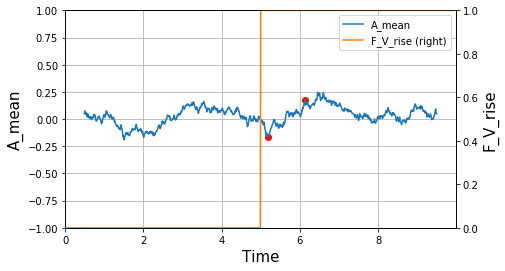

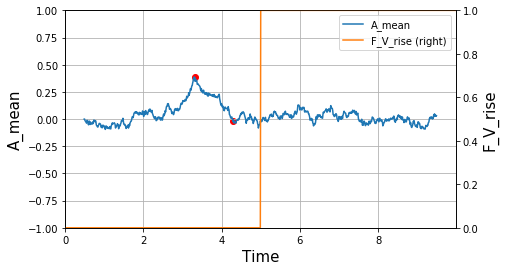

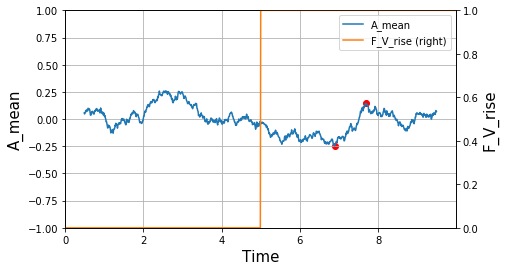

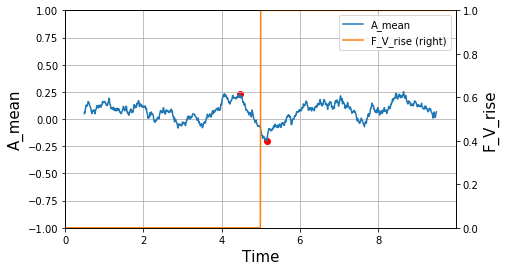

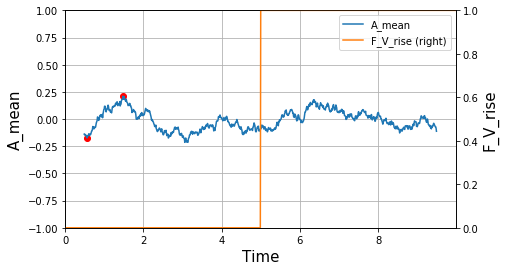

In [35]:
for path in pathlib.Path('data').glob('*.csv'):
    input_f = str(path.name)
    tar_NE = df_meta[df_meta['file_name']==input_f].tar_NE.values[0]
    tar_GAIRCYL = df_meta[df_meta['file_name']==input_f].tar_GAIRCYL.values[0]
    num = df_meta[df_meta['file_name']==input_f].num.values[0]
    output_f = str(tar_NE) + "_" + str(tar_GAIRCYL) + "_" + str(num)
    
    df = pd.read_csv(path, index_col =0)#データ読み込み
    df = ave_move(df, dt_ave_m, sampling, signal_name)#信号の移動平均算出
    df = detect_rise(df, F_CH_name, criteria)#立ち上がり検出
    #df = detect_down(df, F_CH_name, criteria)#立ち下がり検出
    df_W = window_data(df,w_t, F_CH_point)#検出ポイントの前後w_t区間を抽出
    #fig, spike_d = get_d_signal(df_W, dt_d_max, sampling, signal_name )
    spike_d = get_d_signal(df_W, dt_d_max, sampling, signal_name )
    
    df_meta_o.loc[df_meta_o['file_name']==input_f,'signal_d'] = spike_d[0]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'min_v'] = spike_d[1]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'max_v'] = spike_d[2]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'min_t'] = spike_d[3]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'max_t'] = spike_d[4]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'jpeg_path'] = 'output/' + output_f + '.jpeg'
    fig = plot_signal(df_W, spike_d, plot_sig, y1_name, y2_name, x_name)
    output_jpeg('output/'+output_f, fig)

In [41]:
df_meta_o.to_csv("meta_jpeg.csv")

### エクセルファイルに画像ファイル出力
(引用) https://qiita.com/nshinya/items/a46ef0002284d2f77789

In [43]:
import pandas as pd
import openpyxl
from openpyxl.drawing.image import Image

df = pd.read_csv('meta_jpeg.csv', index_col=0)
# 3列目に画像のパスが入った列を挿入する。この列をテンプレート内でimgタグに変換する。
df.insert(0, "image", df["jpeg_path"])

# 画像埋め込み先の列
IMAGE_COL = "A"

# Excel変換
xl_path = "table.xlsx"
df.to_excel(xl_path, index=False)

# Excelロード
wb = openpyxl.load_workbook(xl_path)
# Activeシート取得
ws = wb.active

# 列幅を調整
for c in ws.columns:
    ws.column_dimensions['A'].width = 30

def image_column(worksheet, image_column):
    ws = worksheet

    # 列数を取得
    R_NUM = len(list(ws.rows))

    # 画像貼り付け
    # 行番号は1始まり。1行目はヘッダなので飛ばす
    for i in range(1, R_NUM):
        idx = i + 1
        cell_name = image_column + str(idx)
        c = ws[cell_name]
        try:
            # 画像ファイルのロード
            img = Image(c.value)
            # 画像の幅を200pxにする
            aspect = float(img.height) / img.width
            img.width = 200
            img.height = aspect * 200
            # 画像を貼り付ける
            ws.add_image(img, cell_name)
            # セルの高さを調整
            ws.row_dimensions[idx].height = img.height
            # セルの文字列は消しておく
            c.value = ""
        except FileNotFoundError:
            # 画像ファイルが見つからない場合はスキップ
            pass

image_column(ws, IMAGE_COL)

# 保存
wb.save(xl_path)

### 立上り検出

In [24]:
def detect_rise(df, signal_name, criteria):
    df[signal_name] = df[signal_name].map(lambda x: 1 if x >= criteria else 0)
    df[signal_name + '_point'] = df[signal_name].diff()==1
    return df

### 立ち下がり検出

In [25]:
def detect_down(df, signal_name, criteria):
    df[signal_name] = df[signal_name].map(lambda x: 1 if x >= criteria else 0)
    df[signal_name + '_point'] = df[signal_name].diff()==-1
    return df

### 移動平均を求める  
窓関数を適用し，その間にて，演算する  
(参考)https://note.nkmk.me/python-pandas-rolling/

In [26]:
def ave_move(df, dt, sampling, signal_name):
    n = int(dt / sampling)
    #df['F_CH_rise'] = df.F_CH.diff()==1
    df[signal_name + '_mean'] = df[signal_name].rolling(n, center = True).mean()
    return df

### 領域を指定しデータを抽出する  
（参考) https://note.nkmk.me/python-pandas-diff-pct-change/

In [27]:
def window_data(df, w_t, F_CH_rise):
    t_rise = df[df[F_CH_rise]].index.values[0]
    df['F_WINDOW'] = df.index.map(lambda x: True if (x <  w_t + t_rise) & (x > t_rise - w_t) else False )
    df_W = df[df['F_WINDOW']].copy()
    df_W.index = np.arange(0, df.F_WINDOW.sum())/100
    return df_W

### 最大値を抽出し、プロットする

In [28]:
def get_d_signal(df_W, dt, sampling, signal_name):
    n = int(dt / sampling)
    df_W[signal_name + '_max'] =df_W[signal_name + '_mean'].rolling(n, center=True).max()
    df_W[signal_name + '_min'] = df_W[signal_name + '_mean'].rolling(n, center= True).min()
    df_W[signal_name + '_delta'] = df_W[signal_name + '_max'] - df_W[signal_name + '_min']
    signal_dmax = np.nanmax(df_W[signal_name + '_delta'])
    df_W['F_' + signal_name + '_max_d'] =df_W[signal_name + '_delta'] .map(lambda x : 1 if x == signal_dmax else 0)
    pos_mm = df_W[df_W['F_' + signal_name + '_max_d'].diff().map(lambda x: abs(x)) == 1].index.values
    min_t = round(pos_mm[1] - dt/2 - sampling , 2)
    max_t = round(pos_mm[0] + dt/2- sampling , 2)
    min_value = df_W[df_W.index == min_t][signal_name + '_mean'].values[0]
    max_value = df_W[df_W.index == max_t][signal_name + '_mean'].values[0]
    return [signal_dmax, min_value, max_value, min_t, max_t]

In [29]:
def plot_signal(df_W, features_sig, plot_sig, y1_name, y2_name, x_name):
    #fig = plt.scatter([features_sig[3], features_sig[4]],[features_sig[1], features_sig[2]], color = 'red')
    fig = df_W[[i for i in plot_sig]].plot(secondary_y=[y2_name], figsize=(7,4),legend="best",grid=True)
    fig.scatter([features_sig[3], features_sig[4]],[features_sig[1], features_sig[2]], color = 'red')
    # 左y軸のラベル
    fig.set_ylabel(y1_name, fontsize=15)

    # 右y軸のラベル
    fig.right_ax.set_ylabel(y2_name, fontsize=15)

    # x軸のラベル
    fig.set_xlabel(x_name, fontsize=15)
    
    # 左y軸の描画範囲 余裕を持たせるために下限上限共に-1, +1
    fig.set_ylim(-1, 1)

    # 右y軸の描画範囲
    fig.right_ax.set_ylim(0,1)

    return fig


### 画像の出力

In [30]:
def output_jpeg(file_name, fig):
    fig.figure.savefig(file_name+'.jpeg')